In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from itertools import combinations


In [2]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train = train.sort_values(['STOCK', 'DATE']).reset_index()
test  = test.sort_values(['STOCK', 'DATE']).reset_index()

## Dataset Imputation

Based on our findings during the EDA, we are now imputing missing values.

In [3]:
ret_features = [f'RET_{day}' for day in range(1,6)]
ret_to_drop = train[(train[ret_features].isna().sum(axis=1)/(train[ret_features].shape[1]) >= 1)][ret_features]

train.drop(index=ret_to_drop.index, inplace=True) # Drop all rows with no observed returns over the past 5 days

In [4]:
for column in [f'VOLUME_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

In [5]:
for column in [f'RET_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

# Feature Engineering

In [6]:
new_features = []

Each of these features is motivated by financial theories or empirical evidence suggesting their relevance in predicting stock returns.

Regrouping the features by SECTOR/DATE

In [7]:
# Conditional aggregated features
shifts = [1,2,3,4] 
statistics = ['mean']
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['RET']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data.groupby(gb_features)[feat].transform(stat)

Under the assumption, that 1 week = 5 days, compute the weekly average and standard deviation of the past four weeks. 

In [8]:
# This cell includes some statistics that did not improve the accuracy and were not used further
weeks = 4
statistics = ['mean', 'std']
gb_features_list = [['STOCK', 'DATE']]

target_features = ['RET', 'VOLUME'] 
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for stat in statistics:
            for week in range(weeks):
                name = f'{stat}_{target_feature}_STOCK_WEEK_{week+1}'
                new_features.append(name)
                for data in [train, test]:
                    if stat == 'mean':
                        if target_feature == 'VOLUME':
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1).abs()
                        else:
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1)
                    elif stat == 'std':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].std(axis=1)
                    elif stat == 'min':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].min(axis=1)
                    elif stat == 'max':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].max(axis=1)
                    elif stat == 'median':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].median(axis=1)

Next, I implement the relative measure of the stock's volume compared to its sector. It is similar to normalization.

In [9]:
shifts = [1,2,3,4] 
statistics = ['sum']
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_VOLUME_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_VOLUME_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

Same but now for the return.

In [10]:
shifts = [1,2,3,4] 
statistics = ['sum'] 
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_RET_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_RET_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

We add a more dynamic feature, called residual return momentum. We do so by calculating the average return over day D-1,...,D-10 and subtract the return of day D to obtain an idea where our stock might go. The residual return momentum reflects recent performance trends. 

In [11]:
weeks = [2]
targets = ['RET', 'VOLUME']

for target in targets:
    for week in weeks: 
        window_size = 5*week
        name = f'{target}_{window_size}_day_momentum'
        new_features.append(name)
        for data in [train, test]:
            _data = data.copy()
            rolling_mean_target = _data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(2, window_size+1)]].mean()
            target_1_mean = _data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_1']].mean()
            target_1_mean_aligned, rolling_mean_target_aligned = target_1_mean.align(rolling_mean_target, axis=0, level='SECTOR')
            target_momentum = target_1_mean_aligned.sub(rolling_mean_target_aligned.mean(axis=1), axis=0)
            target_momentum.rename(columns={f'{target}_1': name},inplace=True)
            placeholder = _data.join(target_momentum, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]

Compute the standard deviation of the averages to measure volatility (conditioned on sector). 

In [12]:
weeks = [2]
targets = ['RET', 'VOLUME']

for week in weeks: 
    window_size = 5*week
    for target in targets: 
        name = f'{window_size}_day_mean_{target}_vola'
        new_features.append(name)
        for data in [train, test]:
            rolling_std_target = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(1,window_size+1)]].mean().std(axis=1).to_frame(name)
            placeholder = data.join(rolling_std_target, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]

We are now going to add the relative strength index per sector. The RSI measures the speed and change of price movements.

In [13]:
targets = ["RET"]
window_size = 20
name = f"RSI_SECTOR_DATE_{window_size}"
new_features.append(name)

for target in targets:
    for data in [train, test]:
        _data = data.copy()
        avg_gain_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x>0].mean(), axis=1)
        avg_loss_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x<0].mean(), axis=1).abs()
        rs_sector_day = avg_gain_sector_day/avg_loss_sector_day
        rsi_sector_date = 100 - 100/(1+rs_sector_day)
        placeholder = _data.join(rsi_sector_date.to_frame(name), on=['SECTOR', 'DATE'], how='left')
        data[name] = placeholder[name]

Now add an aggregated advance-decline line indicator conditioned on sector. ADLsum​=∑​Net Advances_i (signal overall market trends)

In [14]:
window_size = 5
name = 'Sum_ADL'
new_features.append(name)
for data in [train, test]:
    _data = data.copy()
    sum_adl = ((_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x>0).sum()) - (_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x<0).sum())).sum(axis=1)
    placeholder = _data.join(sum_adl.to_frame(name), on=['SECTOR', 'DATE'], how='left')
    data[name] = placeholder[name]

# Feature Selection

In [15]:
target = 'RET'

n_shifts_ret = 5  # If you don't want all the shifts to reduce noise
n_shifts_vol = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts_ret)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts_vol)]
features += new_features  # The conditional features
train[features].head()

RET_1     RET_2     RET_3     RET_4     RET_5  VOLUME_1  VOLUME_2  \
0 -0.005967  0.009031  0.008296  0.002638  0.012739  0.136699 -0.003109   
1  0.001348  0.011100  0.012023 -0.016477  0.005654 -0.269520 -0.085622   
2 -0.014405  0.003614  0.011156  0.000000  0.002700  0.192655  0.353804   
3  0.008938  0.002662  0.002490  0.014896 -0.002252  0.430916  0.175444   
4 -0.006523 -0.007632  0.004756  0.005466 -0.006111 -0.060371 -0.037806   

   VOLUME_3  VOLUME_4  VOLUME_5  ...  \
0  0.015042  0.570881  0.746002  ...   
1 -0.324746 -0.155429 -0.379779  ...   
2 -0.133228 -0.085529  0.001736  ...   
3 -0.083462 -0.352598 -0.130800  ...   
4 -0.251701 -0.020684 -0.503069  ...   

   mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE  \
0                                         0.005523   
1                                         0.041524   
2                                        -0.008523   
3                                         0.012921   
4                                        -0.012370   

   mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE  \
0                                         0.021981   
1                                        -0.009089   
2                                        -0.000223   
3                                        -0.024078   
4                                         0.003576   

   mean_RET_STOCK_WEEK_3_/total_RET_of_SECTOR_DATE  \
0                                         0.002407   
1                                         0.001913   
2                                         0.024546   
3                                        -0.004283   
4                                         0.362947   

   mean_RET_STOCK_WEEK_4_/total_RET_of_SECTOR_DATE  RET_10_day_momentum  \
0                                         0.018267            -0.002850   
1                                        -0.031775             0.000370   
2                                         0.004293            -0.018693   
3                                        -0.167389            -0.008145   
4                                         0.038859            -0.010167   

   VOLUME_10_day_momentum  10_day_mean_RET_vola  10_day_mean_VOLUME_vola  \
0               -0.029705              0.007561                 0.048838   
1               -0.065635              0.005089                 0.201796   
2               -0.081960              0.012265                 0.116282   
3                0.053479              0.006282                 0.116467   
4               -0.083851              0.006679                 0.112301   

   RSI_SECTOR_DATE_20  Sum_ADL  
0           49.364457      292  
1           59.212854       44  
2           49.351113      -14  
3           51.510651       98  
4           54.197333       13  

[5 rows x 44 columns]

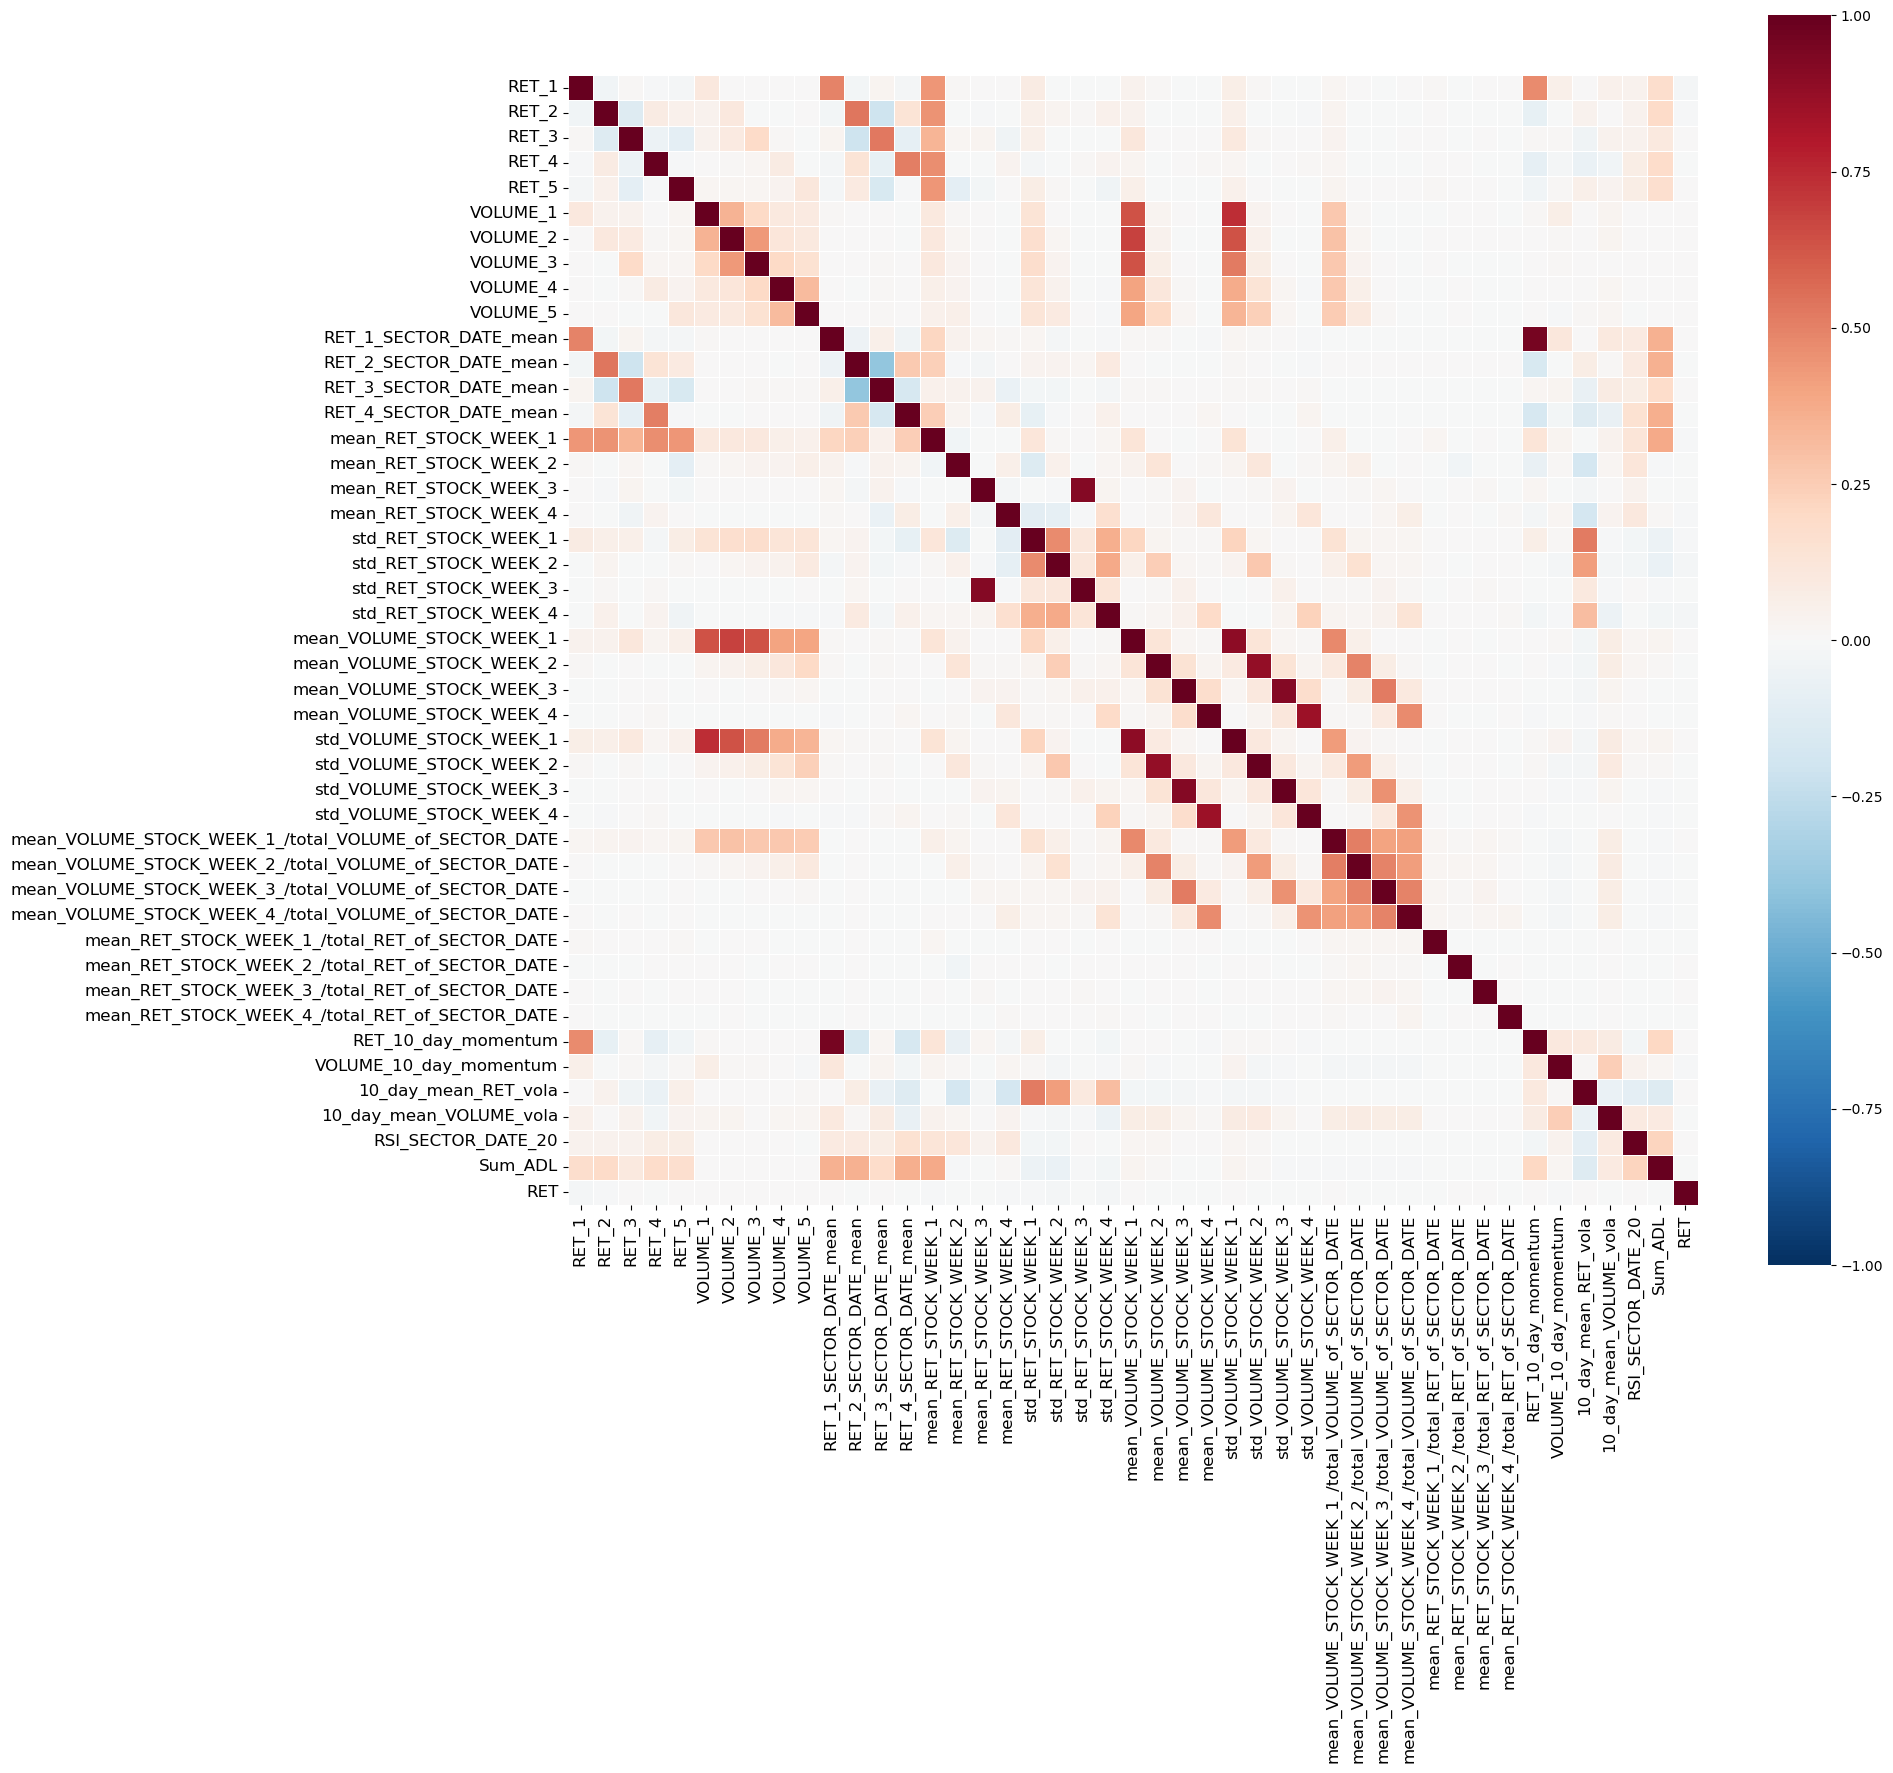

In [17]:
corr_features = features + ['RET']
corr_matrix = train[corr_features].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Model Selection and Local Score

Let's continue with evaluating the models. I used the LGBM version of RF to quickly test and identify new promising features.

In [18]:
X_train = train[features]
y_train = train[target]

# Choose parameters of the LGBM RF such that they coincide with the RandomForestClassifier 
parameters = {
    'boosting_type': 'rf',
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1, 
    'feature_fraction': np.log(X_train.shape[0])/X_train.shape[0],
    'objective': 'binary',
    'verbose': -1
}

rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train / test

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    #model = LGBMClassifier(**parameters)
    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train.values.reshape(-1))

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

Fold 1 - Accuracy: 51.01%


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

Fold 2 - Accuracy: 51.22%


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

Fold 3 - Accuracy: 52.95%


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

Fold 4 - Accuracy: 52.04%
Accuracy: 51.80% [51.04 ; 52.57] (+- 0.76)


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

<Axes: >

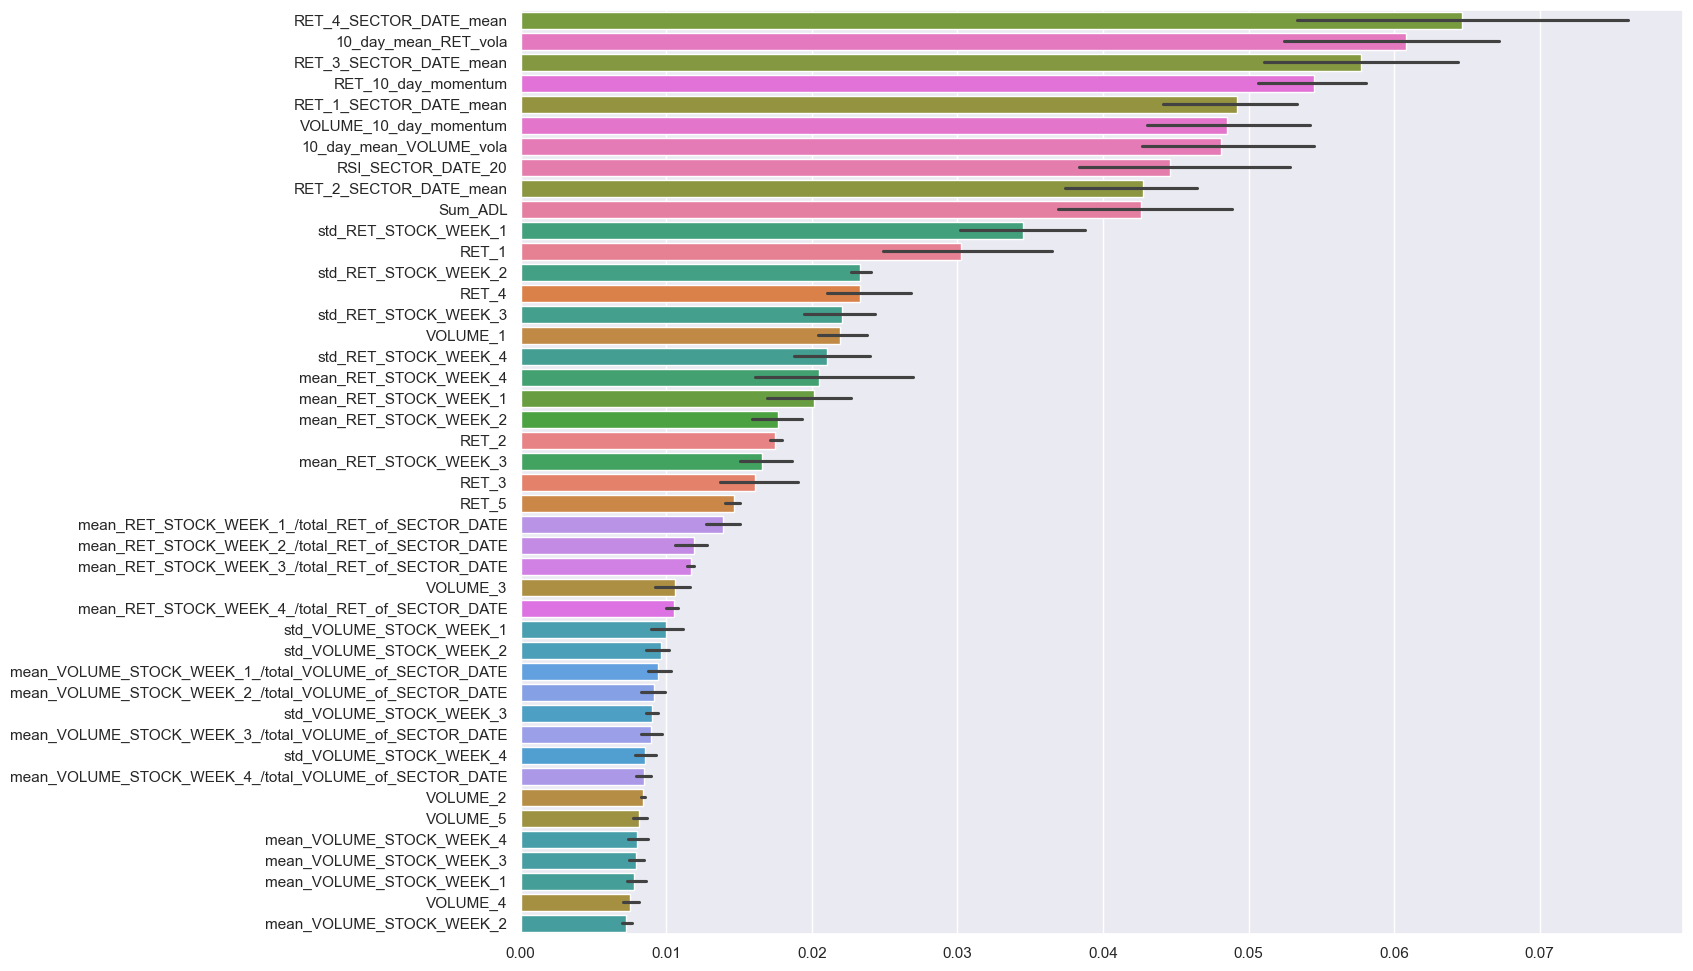

In [19]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

# Prediction

In [20]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

# Use diferend decision rules and compare their accuracy
sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print('median', accuracy_score(y_pred_train,y_train))

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.mean()).values
print('mean', accuracy_score(y_pred_train,y_train))

print('built-in', accuracy_score(model.predict(X_train),y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)

/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

median 0.5817230670199045


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

mean 0.5813075402496524


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

built-in 0.5749905725862818


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

Best submission: 

In [22]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)

/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

0.5817230670199045


/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

In [24]:
submission.value_counts(normalize=True)

RET
False    0.500068
True     0.499932
Name: proportion, dtype: float64

Corresponding feature importances:

/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/opt/anaconda3/envs/bikes-count/lib/python3.13

<Axes: >

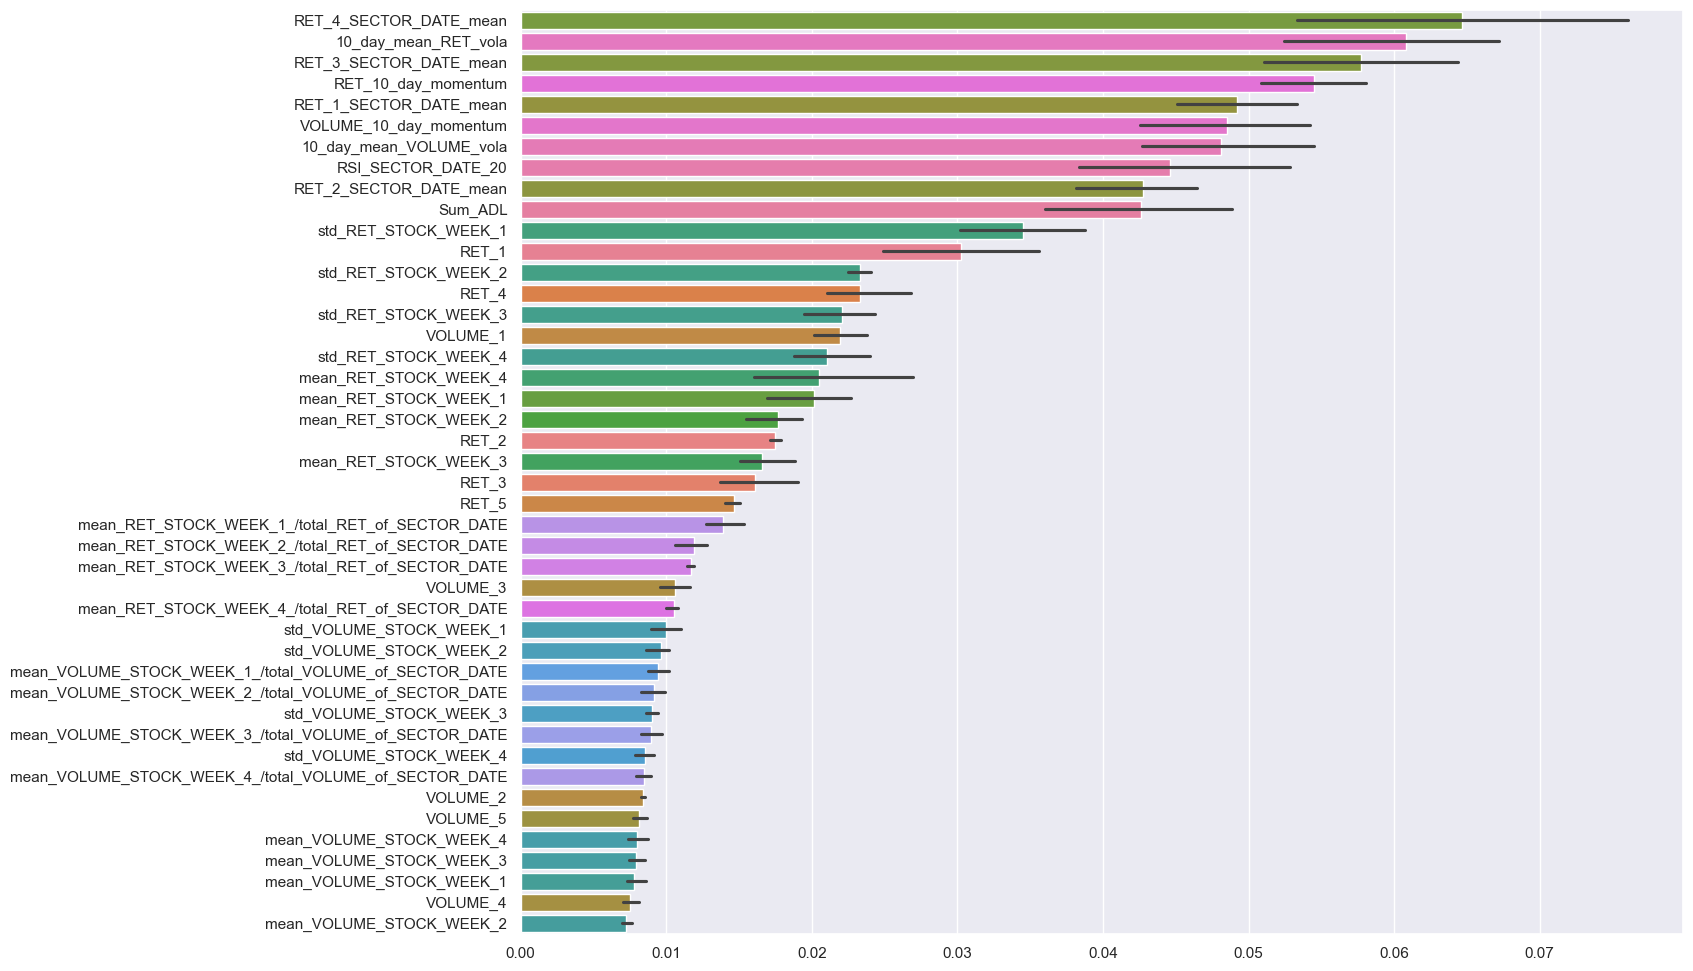

In [25]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.set(rc={'figure.figsize':(15,12)})
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)